# Importing all the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Cost Function

In [2]:
def compute_cost(x, y, W, b):
    m = x.shape[0]
    cost_sum = 0.0

    for i in range(m):
        # f_wb: (3,)
        f_wb = np.dot(x[i], W) + b
        # cost_i: (3,)
        cost_i = (f_wb - y[i]) ** 2
        cost_sum += np.sum(cost_i)   # scalar

    total_cost = (1 / (2 * m)) * cost_sum
    return total_cost

# Gradient Function

In [3]:
def compute_gradient(x, y, W, b):
    m, n = x.shape
    k = y.shape[1]  # should be 3

    dj_dW = np.zeros((n, k))
    dj_db = np.zeros((k,))

    for i in range(m):
        f_wb = np.dot(x[i], W) + b     # (k,)
        err_i = f_wb - y[i]            # (k,)

        for j in range(n):
            dj_dW[j, :] += err_i * x[i, j]  # (k,)

        dj_db += err_i

    dj_dW /= m
    dj_db /= m

    return dj_dW, dj_db

# Gradient Descent

In [4]:
def gradient_descent(x, y, w_in, b_in, alpha, iterations):
    w = w_in
    b = b_in
    cost_history = []

    for i in range(iterations):
        dj_dw, dj_db = compute_gradient(x, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        cost = compute_cost(x, y, w, b)
        cost_history.append(cost)

        if i % 100 == 0:
            print(f"Iteration: {i}  Cost: {cost}")

    return w, b, cost_history

# Loading the dataset

In [49]:
df = pd.read_csv('../datasets/synthetic_power_demand_future_load_targets.csv')
train_df = df.iloc[:2400].copy()
print("First 2400 datapoints loaded for training purposes!")

# Create time features (missing from load dataset)
train_df['hour_of_day'] = pd.to_datetime(train_df['timestamp']).dt.hour
train_df['day_of_week'] = pd.to_datetime(train_df['timestamp']).dt.dayofweek
train_df['is_weekend'] = (train_df['day_of_week'] >= 5).astype(int)
train_df['is_holiday'] = 0  # No holidays in dataset

print("Time features created!")

First 2400 datapoints loaded for training purposes!
Time features created!


# Real-time Electricity Load Hourly Forecasting**

- Horizon: Next 1h  
- Inputs (X columns):
  - hour_of_day
  - day_of_week  
  - is_weekend
  - is_holiday
  - lag_t+1, lag_t+2, ........... , lag_t+24
  - temperature, humidity
- Outputs (y label):
  - load_mw (next hour)


In [50]:
X_train = train_df[["hour_of_day", "day_of_week", "is_weekend", "is_holiday",
    "temperature", "humidity"
]].values
y_train = train_df[["load_lag_t+1", "load_lag_t+2", "load_lag_t+3", "load_lag_t+24"]].values

# scaling the values
scaler_X = StandardScaler()
X_norm = scaler_X.fit_transform(X_train)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y_train)

print("Data columns selected successfully!")

Data columns selected successfully!


# Initials

In [51]:
m, n = X_norm.shape
w_in = np.zeros((n, 4)) 
b_in = np.zeros((4, )) 

# Training

In [52]:
w, b, cost_history = gradient_descent(
    X_norm, y_norm,
    w_in, b_in,
    alpha = 0.01,
    iterations = 5000
)

print("Trained Successfully on first 2400 datapoints!")

Iteration: 0  Cost: 1.9381438635908308
Iteration: 100  Cost: 0.4509951829320442
Iteration: 200  Cost: 0.3940475266102121
Iteration: 300  Cost: 0.3792557218537283
Iteration: 400  Cost: 0.37241555705511814
Iteration: 500  Cost: 0.3687829779138385
Iteration: 600  Cost: 0.3667028860835282
Iteration: 700  Cost: 0.3654604816526629
Iteration: 800  Cost: 0.36470135657315583
Iteration: 900  Cost: 0.36423165469919494
Iteration: 1000  Cost: 0.3639388147477061
Iteration: 1100  Cost: 0.3637552849321848
Iteration: 1200  Cost: 0.3636397918873582
Iteration: 1300  Cost: 0.36356685817982903
Iteration: 1400  Cost: 0.36352065371395703
Iteration: 1500  Cost: 0.3634912954828858
Iteration: 1600  Cost: 0.36347258899597706
Iteration: 1700  Cost: 0.36346063800017764
Iteration: 1800  Cost: 0.3634529837865221
Iteration: 1900  Cost: 0.36344806998980383
Iteration: 2000  Cost: 0.3634449085163639
Iteration: 2100  Cost: 0.3634428702837715
Iteration: 2200  Cost: 0.3634415537047852
Iteration: 2300  Cost: 0.3634407017672

# Plot Iterations vs Cost

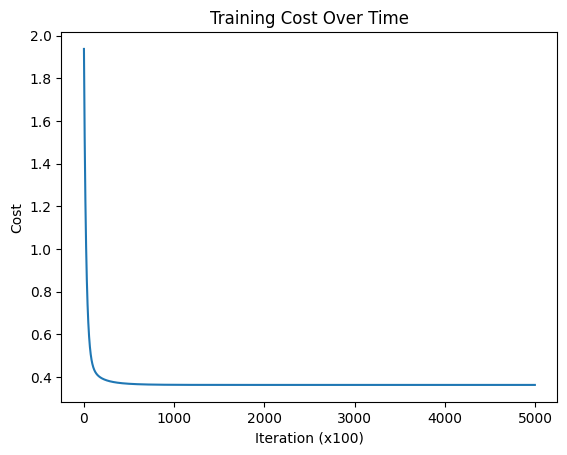

In [53]:
plt.plot(cost_history)
plt.xlabel("Iteration (x100)")
plt.ylabel("Cost")
plt.title("Training Cost Over Time")
plt.show()

# Evaluate on training data

In [54]:
# Predict on training set (scaled space)
y_pred_norm = X_norm @ w + b

# Inverse transform to get real LOAD MW
y_pred = scaler_y.inverse_transform(y_pred_norm)
y_actual = scaler_y.inverse_transform(y_norm)

# Single MAE for load_mw
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_actual, y_pred)

print(f"MAE: {mae:.2f} MW")

MAE: 100.39 MW


/var/folders/_7/_ccmb0hj6nd6bkr2dvys3bg00000gn/T/ipykernel_7019/2457786312.py:2: RuntimeWarning: divide by zero encountered in matmul
  y_pred_norm = X_norm @ w + b
/var/folders/_7/_ccmb0hj6nd6bkr2dvys3bg00000gn/T/ipykernel_7019/2457786312.py:2: RuntimeWarning: overflow encountered in matmul
  y_pred_norm = X_norm @ w + b
/var/folders/_7/_ccmb0hj6nd6bkr2dvys3bg00000gn/T/ipykernel_7019/2457786312.py:2: RuntimeWarning: invalid value encountered in matmul
  y_pred_norm = X_norm @ w + b


# Plot Actual vs Predicted

/var/folders/_7/_ccmb0hj6nd6bkr2dvys3bg00000gn/T/ipykernel_7019/872496801.py:16: RuntimeWarning: divide by zero encountered in matmul
  y_pred_norm = X_test_norm @ w + b
/var/folders/_7/_ccmb0hj6nd6bkr2dvys3bg00000gn/T/ipykernel_7019/872496801.py:16: RuntimeWarning: overflow encountered in matmul
  y_pred_norm = X_test_norm @ w + b
/var/folders/_7/_ccmb0hj6nd6bkr2dvys3bg00000gn/T/ipykernel_7019/872496801.py:16: RuntimeWarning: invalid value encountered in matmul
  y_pred_norm = X_test_norm @ w + b


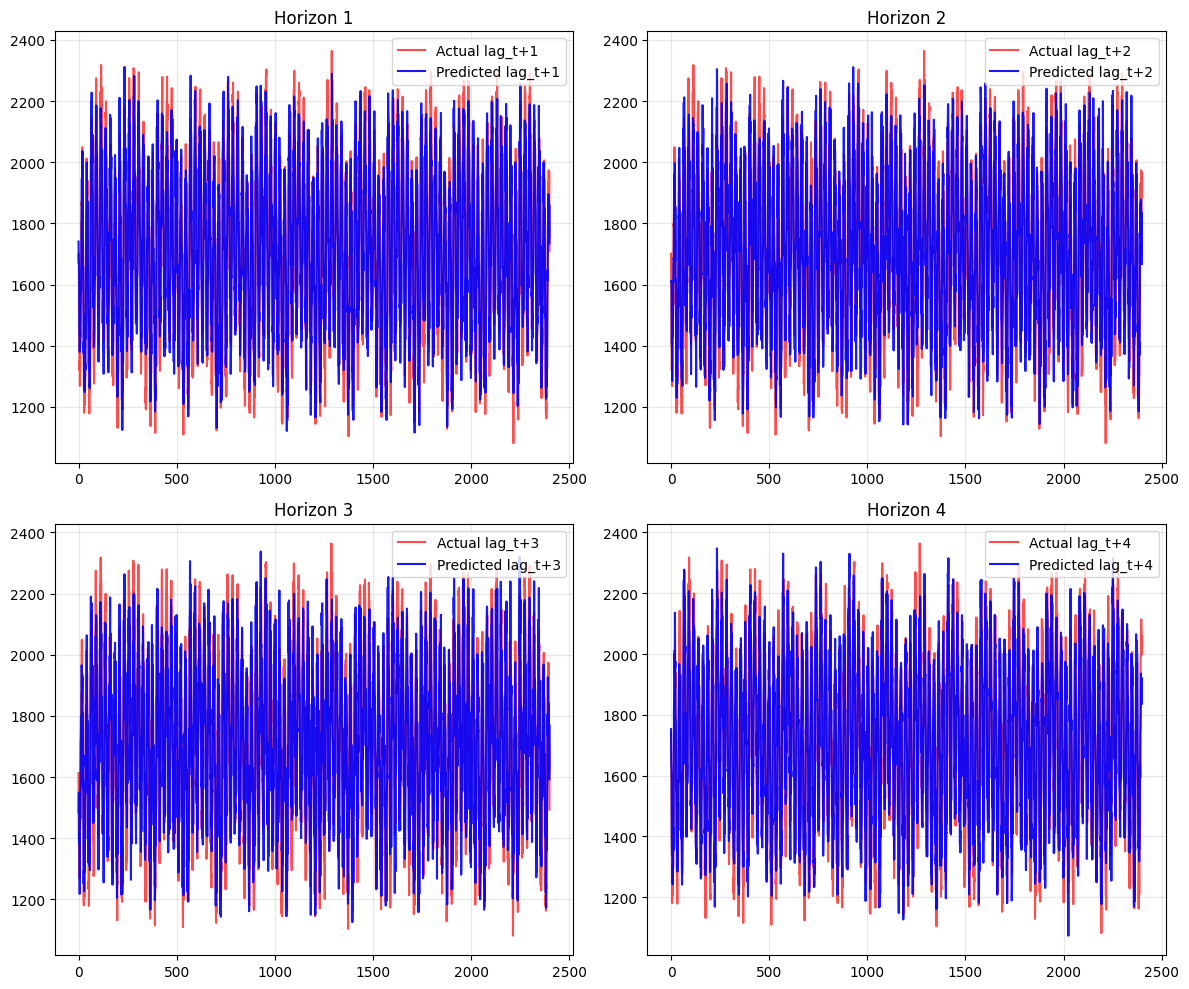

In [55]:
test_df = df.iloc[2400:].copy()

test_df['hour_of_day'] = pd.to_datetime(test_df['timestamp']).dt.hour
test_df['day_of_week'] = pd.to_datetime(test_df['timestamp']).dt.dayofweek
test_df['is_weekend'] = (test_df['day_of_week'] >= 5).astype(int)
test_df['is_holiday'] = 0

X_test = train_df[["hour_of_day", "day_of_week", "is_weekend", "is_holiday",
    "temperature", "humidity"
]].values
y_test = train_df[["load_lag_t+1", "load_lag_t+2", "load_lag_t+3", "load_lag_t+24"]].values

X_test_norm = scaler_X.transform(X_test)
y_test_norm = scaler_y.transform(y_test)

y_pred_norm = X_test_norm @ w + b
y_pred_test = scaler_y.inverse_transform(y_pred_norm)
y_actual_test = scaler_y.inverse_transform(y_test_norm)

# 4 subplots for 4 horizons
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i in range(4):
    axes[i].plot(y_actual_test[:, i], label=f'Actual lag_t+{i+1}', color='red', alpha=0.7)
    axes[i].plot(y_pred_test[:, i], label=f'Predicted lag_t+{i+1}', color='blue', alpha=0.9)
    axes[i].set_title(f'Horizon {i+1}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Saving the model and scalars

In [67]:
MODEL_ARTIFACT = {
  "w": w,            
  "b": b,           
  "scaler_X": scaler_X, 
  "scaler_y": scaler_y,
  "feature_order": [
    "hour_of_day","day_of_week","is_weekend","is_holiday",
    "temperature","humidity"
  ]
}

# User Input Testing

- Inputs
    - 1. System's time
    - 2. Temperature (entered manually in terminal for testing)
    - 3. Humidity (entered manually in terminal for testing)

- Outputs
    - 1. load_mw

In [66]:
from datetime import datetime
import numpy as np
import pandas as pd

# Auto current time
current_time = datetime.now()
hour_of_day = current_time.hour
day_of_week = current_time.weekday()
is_weekend = 1 if day_of_week >= 5 else 0
is_holiday = 0

print("Load Forecaster")
print("Horizons available: 1h, 2h, 3h, 24h")

# User picks N
n_horizons = int(input("\nHow many horizons? (1-4): "))
if n_horizons > 4:
    n_horizons = 4
    print("Max 4 horizons")

horizon_order = [1, 2, 3, 24][:n_horizons]

print(f"\nSequential forecast for {n_horizons} horizons:")
print("=" * 60)

results = []
for i, h in enumerate(horizon_order, 1):
    print(f"\n--- HORIZON {i}/{n_horizons}: {h}h ahead ---")
    temp = float(input("  Temperature (°C): "))
    hum = float(input("  Humidity (%): "))
    
    # Predict THIS horizon
    X_h = np.array([[hour_of_day, day_of_week, is_weekend, is_holiday, temp, hum]])
    X_norm_h = scaler_X.transform(X_h)
    y_pred_norm_h = X_norm_h @ w + b
    load_pred = scaler_y.inverse_transform(y_pred_norm_h)[0, i-1]
    
    print(f"Load {h}h ahead: {load_pred:.1f} MW")
    print()
    
    results.append((h, temp, hum, load_pred))

# Summary table
print("📈 SUMMARY TABLE:")
print("-" * 50)
print(f"{'Horizon':<8} {'Temp':<6} {'Hum':<5} {'Load':<8}")
print("-" * 50)
for h, t, h_, l in results:
    print(f"{h:>7}h {t:>5.1f}°C {h_:>3.0f}% {l:>7.1f} MW")


Load Forecaster
Horizons available: 1h, 2h, 3h, 24h

Sequential forecast for 2 horizons:

--- HORIZON 1/2: 1h ahead ---
Load 1h ahead: 2111.4 MW


--- HORIZON 2/2: 2h ahead ---
Load 2h ahead: 2192.5 MW

📈 SUMMARY TABLE:
--------------------------------------------------
Horizon  Temp   Hum   Load    
--------------------------------------------------
      1h  30.0°C  67%  2111.4 MW
      2h  35.0°C  67%  2192.5 MW
